In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from numpy import array
%matplotlib inline
from operator import itemgetter

In [78]:
# build filter bank convolution kernels
KSIZE = [7,11,15,17,19,21,23,25,27,31,35,39, 47,51]
ORIENTS = 16
PI = np.pi
OR = np.arange(0, np.pi, np.pi / ORIENTS)
def build_filters():
    filters = [] 
    
    #kernel_params = []
     # length will be len(ksize)* len(theta): 7 now
    for scale in KSIZE:
        f_s = []
        for theta in OR:
            kern = cv2.getGaborKernel((scale, scale), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_64F)
            #ksize = 11
            #theta = m*PI/8
            #lambd = 16/3
            #sigma = (5.09030 * 8.0) / (3.0 * PI)
            #gamma = 0.5890
            #psi = 1
            #kern = cv2.getGaborKernel(ksize = (ksize,ksize), sigma = sigma, 
            #        theta= theta, lambd = lambd, 
            #                        gamma = gamma, psi = psi)
            kern /= 1.5*kern.sum() # normalizing the kernal result

            #params = 'theta=%d,\nksize=%d' % (theta * 180 / np.pi, ksize)
            #kernel_params.append(params)
            
            f_s.append(kern)
        filters.append(np.array(f_s))
    return filters
   
 
#Filtering of images here
def process(img, filters):
    accum = np.zeros_like(img)
    all_filtered = []
    
    kern_max = np.zeros_like(filters[0])
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        # returning all the filtered images here
        all_filtered.append((fimg,kern))
        # find maximum element wise and accumulate it in accum
        accum_temp = np.maximum(accum, fimg)
        
        if np.not_equal(accum_temp,accum).any():
            kern_max = kern
            accum = accum_temp
    
    return (accum, kern_max)


## Filter results per image

In [79]:
# Note: Don't turn filtered images to type int
def process_by_image(img, f_s):
    
    imR, imC, imS = img.shape
    filtered_s =[]
    final_f = []
    for f_th in f_s:
        all_filtered = []
        for kern in f_th:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            all_filtered.append(fimg)

            # all_filterd :  filtered result for all filters; find the max next
        #max_resp is a tuple with best filtered image and kernal index
        a_f = np.array(all_filtered)
        final_f.append(a_f)
        (f_max,k_ind) = max_response(a_f)
        filtered_s.append((f_max,k_ind))
    f_thM = max(filtered_s,key=itemgetter(0))    
    kInd_s = filtered_s.index(f_thM)
    return (final_f,kInd_s,f_thM[1])  #contains all filtered, max_scale, max_orient

In [80]:
def max_response(all_filtered):
    print all_filtered.shape
    print 'all filtered shape'
    f_sum = all_filtered.sum(axis=(1,2,3))
    print f_sum
    k_ind = f_sum.argmax()
    f_max = f_sum.max()
    return (f_max,k_ind)

In [78]:
def process_by_filter(imgs, filter):
    all_filtered = [] # filter followed by the images
    all_filtered.append(filter)
 
    for im in imgs:
        fimg = cv2.filter2D(im, cv2.CV_8UC3, filter)
        all_filtered.append(fimg)
        
    return all_filtered

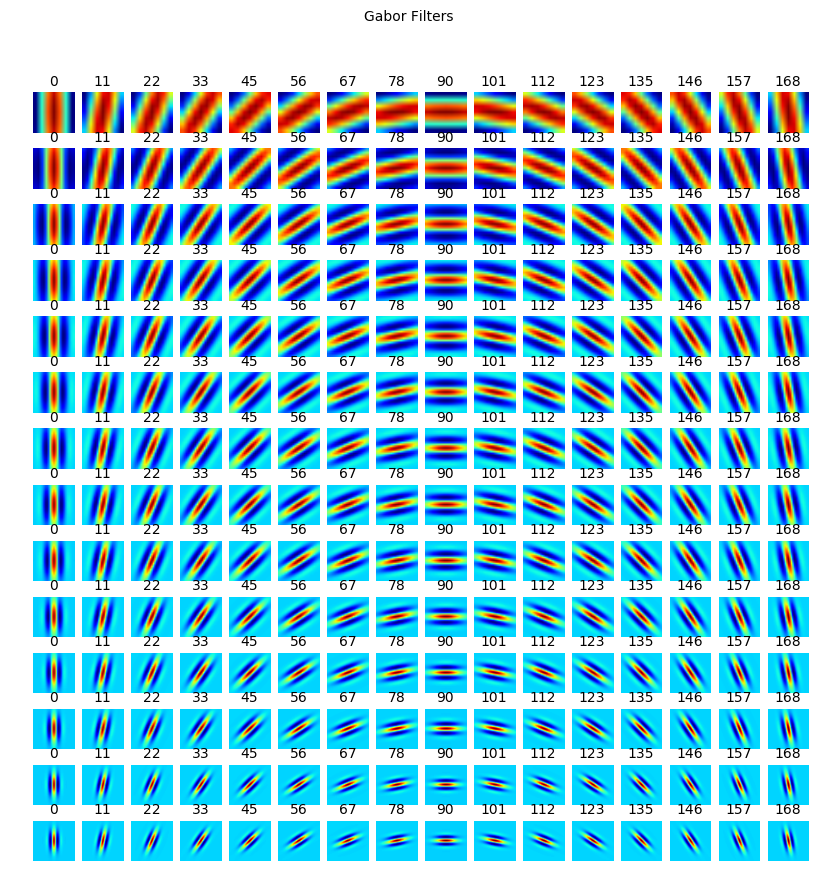

In [81]:
img_1 = cv2.imread('H4.tiff')
img_2 = cv2.imread('H20.tiff')
img_3 = cv2.imread('I65.tiff')
img_4 = cv2.imread('I200.tiff')

image_names = ('H4')#, 'H20', 'I65', 'I200')
images = [img_1]#, img_2, img_3, img_4)

flts_s = build_filters()

fig_fil, axes_fil = plt.subplots(nrows=len(KSIZE), ncols=ORIENTS ,figsize=(10, 10))

fig_fil.suptitle('Gabor Filters', fontsize=10)

for j, f_sc in enumerate(flts_s):
    
    for i, fimg_t in enumerate(f_sc):
        ax = axes_fil[j][i]  
        th = int((np.arange(0, PI, PI / ORIENTS)[i])*(180/PI))
        ax.set_title(th,fontsize=10)
        ax.imshow(fimg_t)
        ax.axis('off')

In [34]:
#process by filter
f_imgs = []
for f in filters:
    f_imgs.append(process_by_filter(images,f))
    

In [35]:
results = []
#f_img = process(img_4, filters)
for i in images:
    fimg = process(i, filters)
    results.append(fimg)

(496, 512, 3)
(16, 496, 512, 3)
all filtered shape
[69397431 69396606 69397431 69396723 69397359 69397776 69397236 69397767
 69396852 69397404 69397557 69397851 69396351 69396723 69396690 69397113]
(16, 496, 512, 3)
all filtered shape
[70987383 70525491 69803940 69539925 69497343 69580524 70000557 71040906
 71633409 70606614 69702120 69473199 69438918 69460245 69616014 70284873]
(16, 496, 512, 3)
all filtered shape
[81450777 78265452 73022166 70358574 69935100 70641216 73935159 79467645
 83340867 78710628 72470256 69930192 69598884 69809436 72007950 77787474]
(16, 496, 512, 3)
all filtered shape
[77912352 77375235 74060013 70887348 70241943 71316060 75018222 78568524
 79091334 77710014 73459944 70264128 69705183 70073730 72909345 76809078]
(16, 496, 512, 3)
all filtered shape
[74633931 75094926 74139609 71388291 70602105 71927172 75059973 76263495
 75692826 75317265 73509669 70602798 69835386 70353771 72941457 74508390]
(16, 496, 512, 3)
all filtered shape
[73081602 73591698 73721112 7

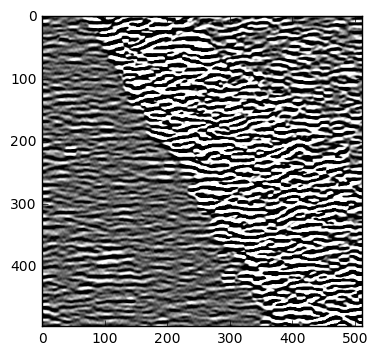

In [82]:
r_img = []
for i in images:
    print i.shape
    res = process_by_image(i, flts_s)
    plt.imshow(res[0][res[1]][res[2]])
    r_img.append(res)

### Display filtered images and the best result

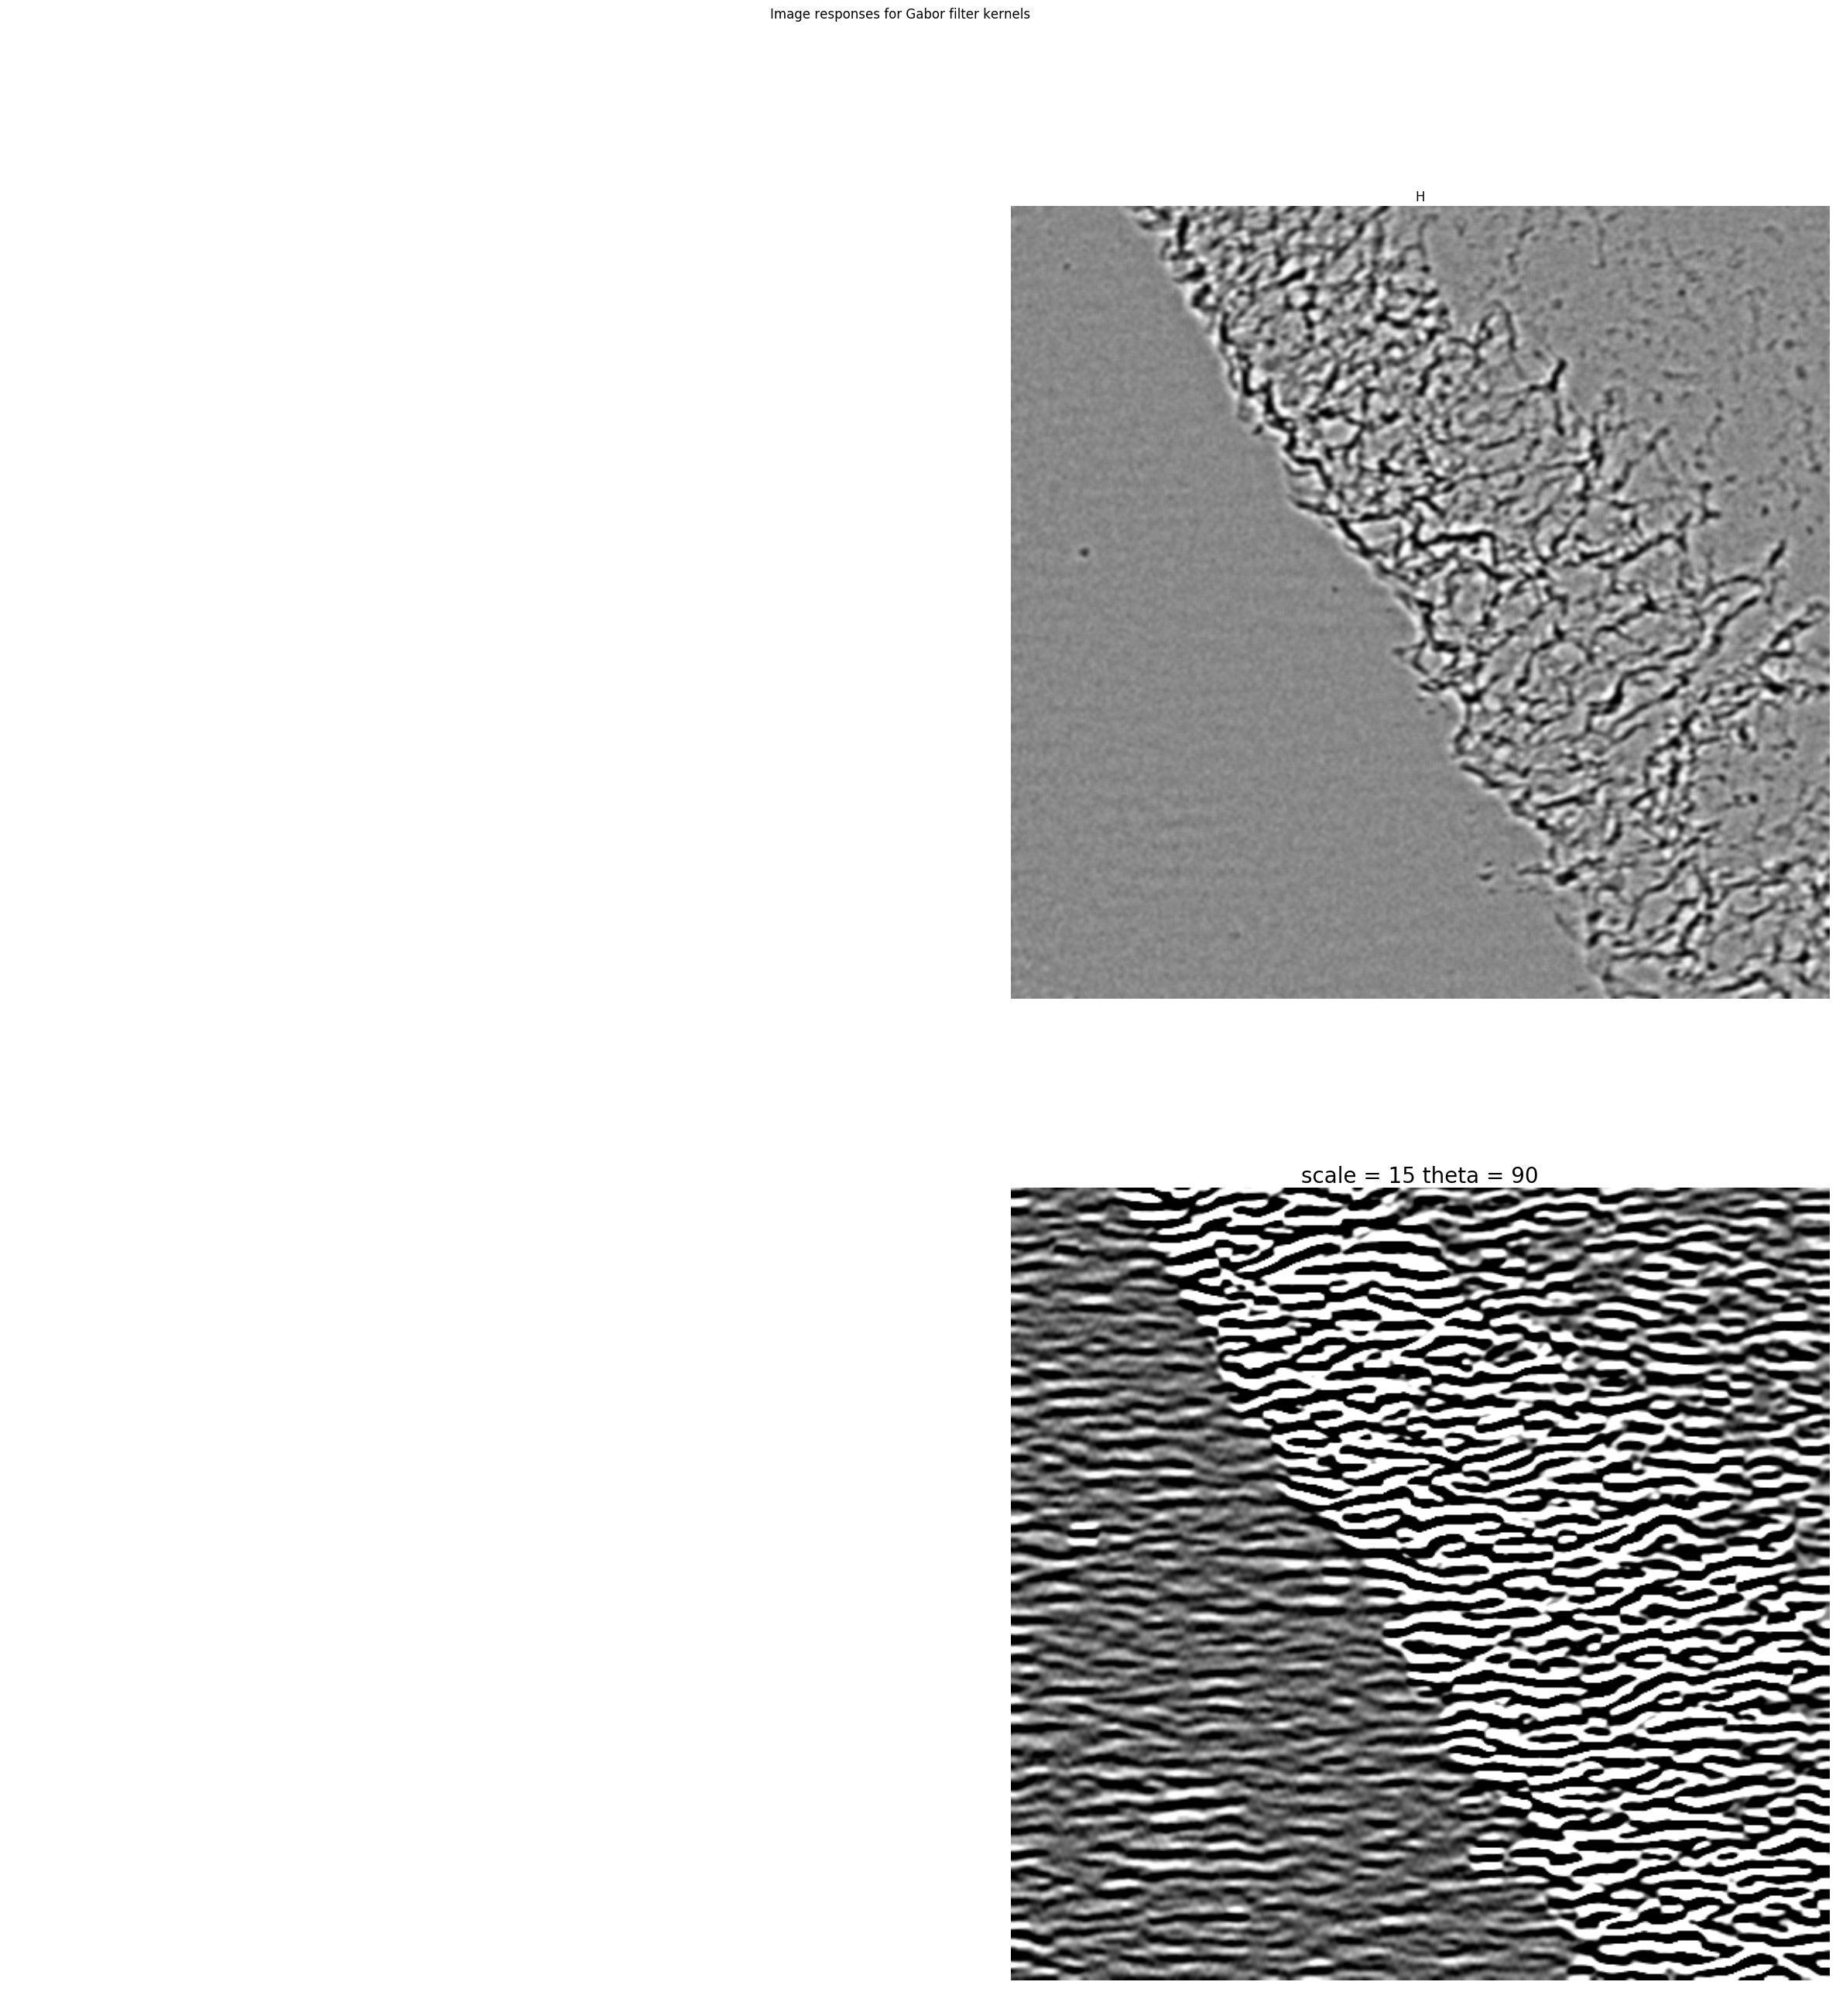

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=len(images)+1,figsize=(30, 30))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
axes[0][0].axis('off')
axes[1][0].axis('off')

for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')
k =0
for i ,f_S in enumerate(r_img): 
    
    max_s = f_S[1]
    max_o = f_S[2]
    k = 0
    for j, f_imgS in enumerate(f_S[0]):
        
        for l, f_imgO in enumerate(f_imgS):

            ax_1 = axes[-1][i+1]
            
            title = 'scale = '+str(KSIZE[max_s])+' theta = '+str(int(OR[max_o]*180/PI))
            ax_1.set_title(title, fontsize=20)
            ax_1.imshow(f_S[0][max_s][max_o])
            ax_1.axis('off')
    

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=len(KSIZE*ORIENTS)+2, ncols=len(images)+1,figsize=(100, 30))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
fig.tight_layout()
axes[0][0].axis('off')
axes[-1][0].axis('off')
#axes[len(ksize*forients)+1][0].axis('off')

for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')
k =0
for i, flt_sc in enumerate(flts_s):   
    for j, flt in enumerate(flt_sc):
        k+=1
        ax = axes[k][0]
        th = int((np.arange(0, PI, PI / ORIENTS)[j])*(180/PI))
        ax.set_title(th, fontsize=12)
        ax.imshow(flt)
        ax.axis('off')
# each r_img contains - (all filtered, max_scale, max_orient)
for i ,f_S in enumerate(r_img): 
    
    max_s = f_S[1]
    max_o = f_S[2]
    max_title = str(KSIZE[max_s])+' '+str(int(OR[max_o]*180/PI))
    k = 0
    for j, f_imgS in enumerate(f_S[0]):
        
        for l, f_imgO in enumerate(f_imgS):
            k+=1
            ax = axes[k][i+1]
            
            ax.imshow(f_imgO)
            ax.axis('off')

    ax_1 = axes[-1][i+1]
    ax_1.set_title(max_title, fontsize=12)
    ax_1.imshow(f_S[0][max_s][max_o])
    ax_1.axis('off')
    plt.imshow(f_S[0][max_s][max_o])
    
plt.show()

### Display accumulated results

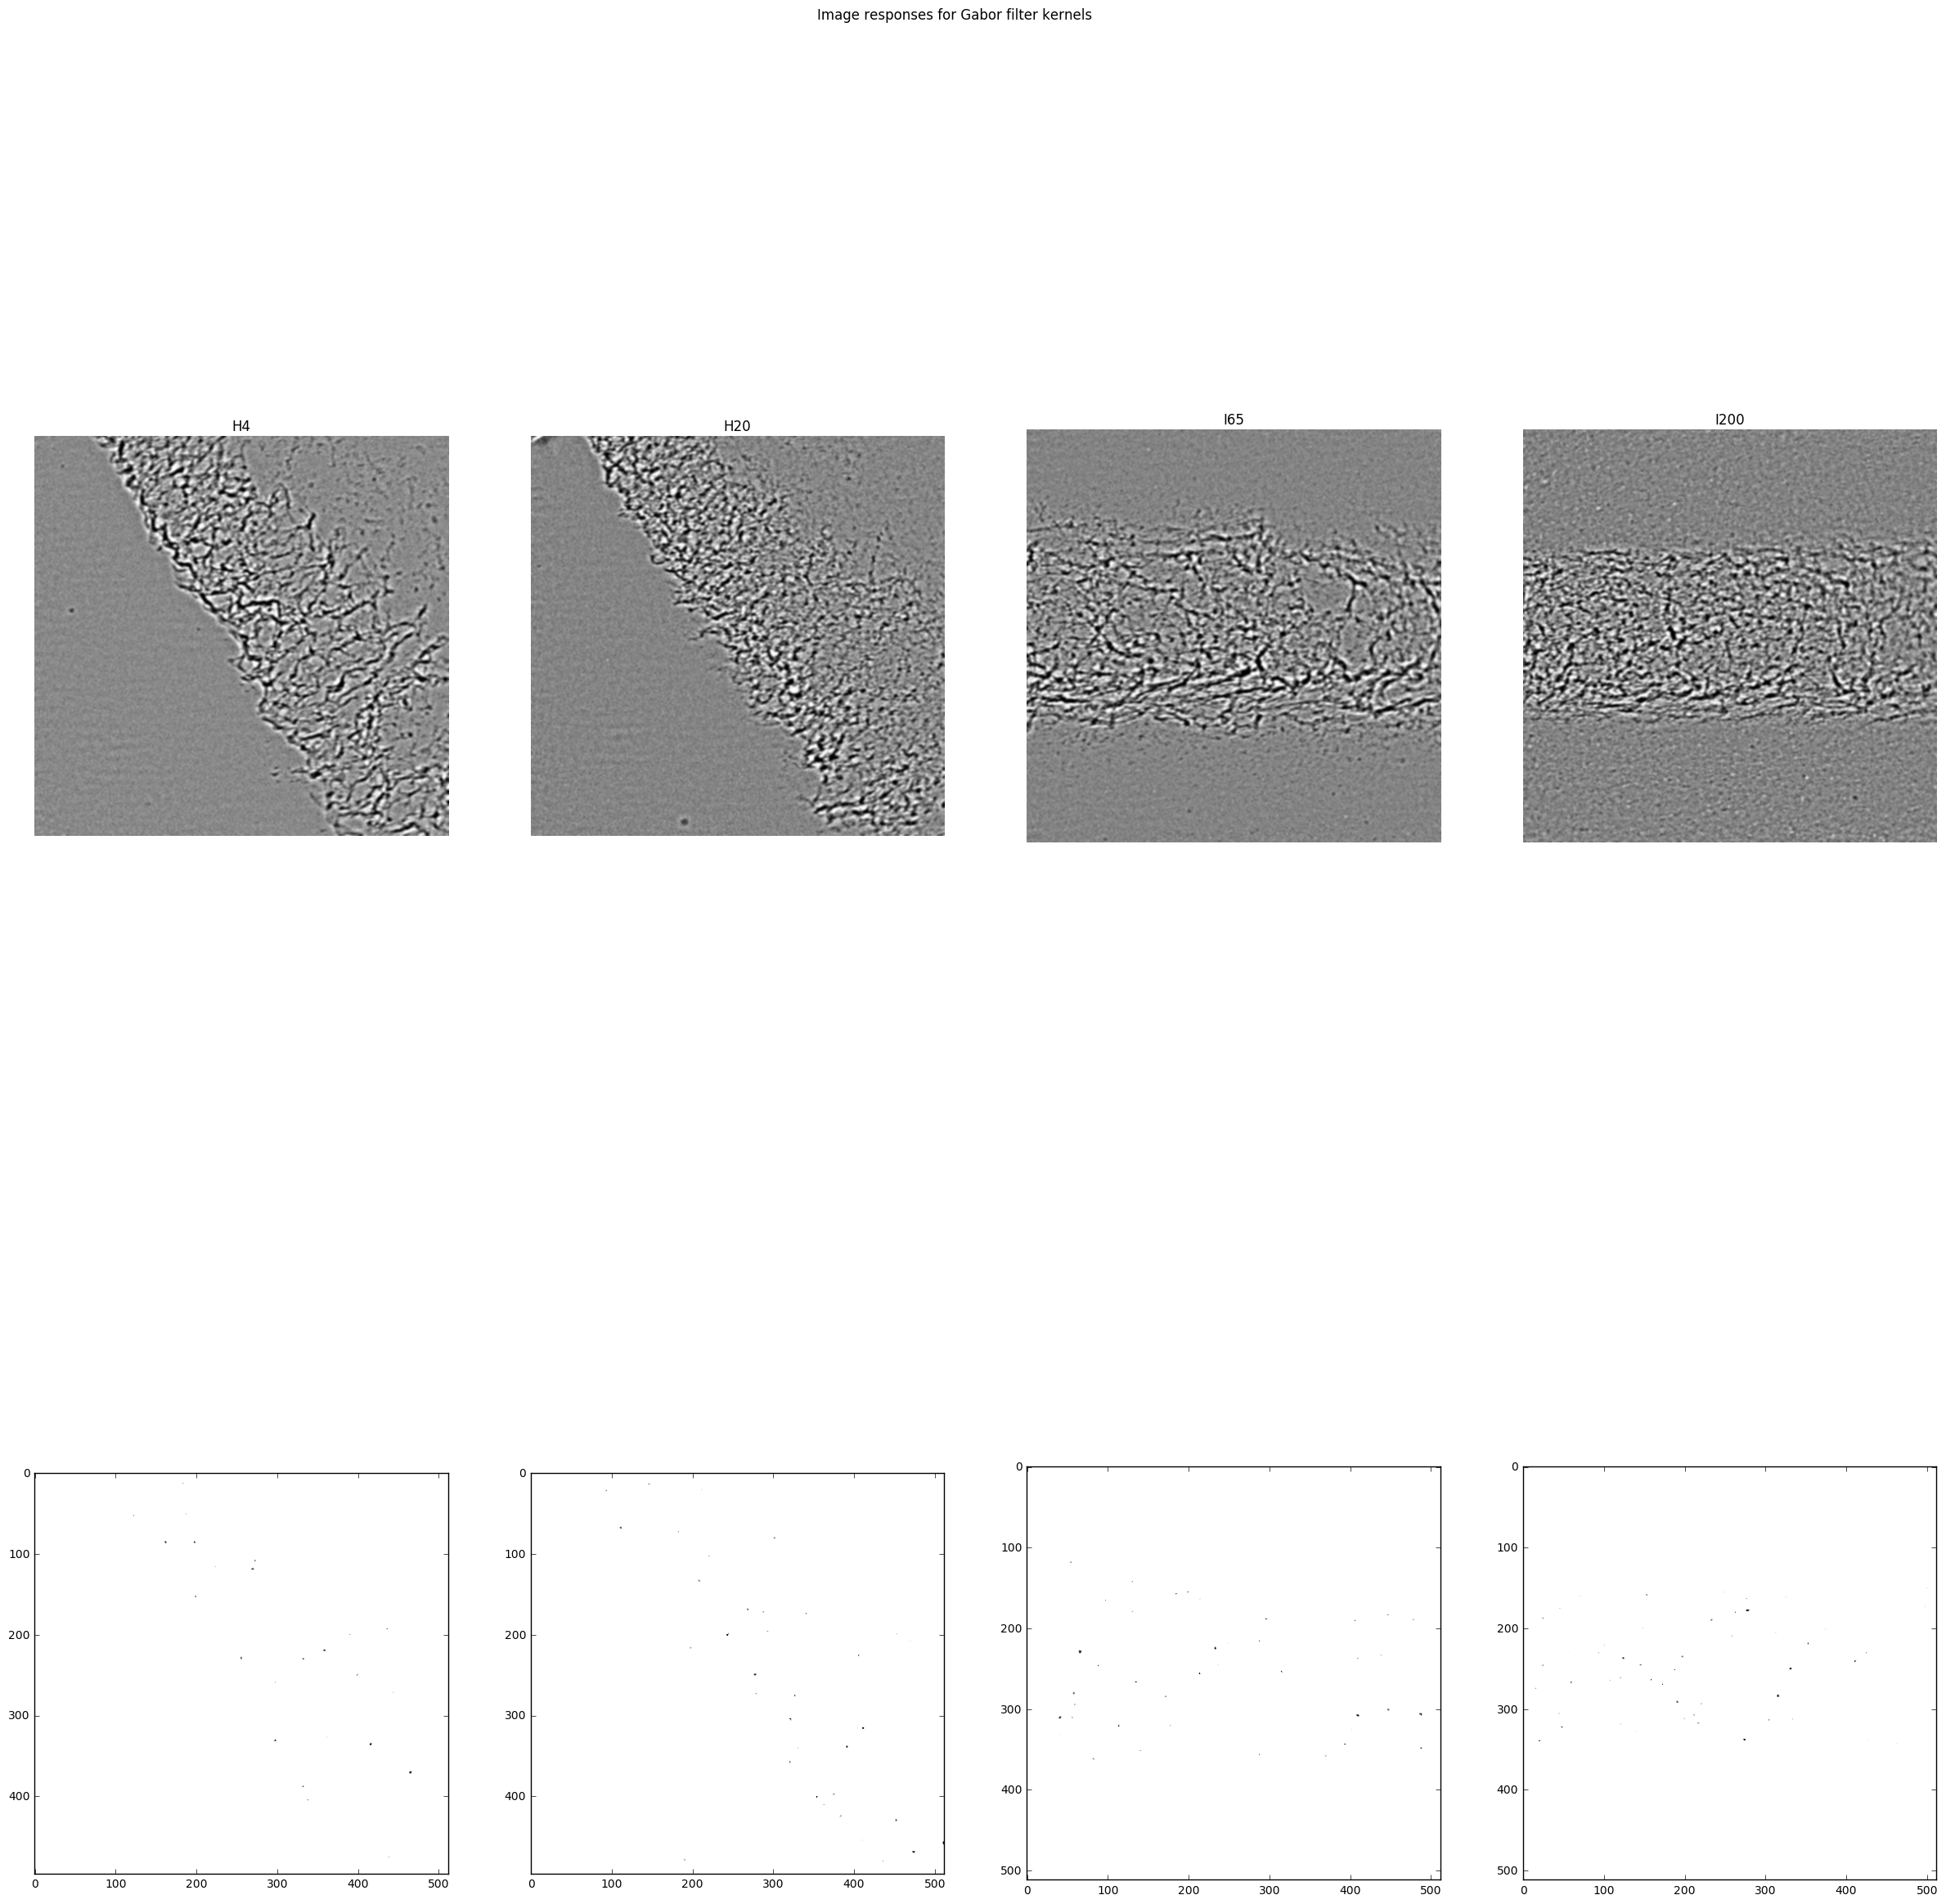

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(30, 30))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

for label, img, ax in zip(image_names, images, axes[0][0:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')

for  f_img , ax_row in zip( results , axes[1][0:]):
    ax = ax_row
    ax.imshow(np.real(f_img[0]))
    
    
plt.show()